# Imports

In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

# Load dataset

In [ ]:
df = pd.read_csv("full_dataset_with_stance_distilbert.csv")

df["video_published_at"] = pd.to_datetime(df["video_published_at"])
df = df.sort_values("video_published_at")

print("Set size:", len(df))
print("Unique dates in set:", df["video_published_at"].nunique())

Set size: 1554327
Unique dates in set: 657


In [ ]:
df.head()

,id,video_title,video_published_at,comment,stance_label
0,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,Get Russia out of Ukraine Now,prorussian
72,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,The West needs to immediately provide Ukraine ...,prorussian
71,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,Rules Based 💩(order). You tell us Russia is we...,prorussian
70,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,Instead of feeding poor people in America we s...,proukrainian
69,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,CNN is the king of that retired US military. A...,prorussian


In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if device.type == "cuda" else torch.float32
).to(device)
model.eval()

Using: cuda


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
def sentiment_score_batch(texts):
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits

    probs = torch.softmax(logits, dim=1).cpu().numpy()

    scores = probs[:, 2] - probs[:, 0]

    return scores

In [16]:
BATCH = 1024
all_scores = []

comments = df["comment"].astype(str).tolist()

for i in tqdm(range(0, len(comments), BATCH)):
    batch = comments[i : i + BATCH]
    batch_scores = sentiment_score_batch(batch)
    all_scores.extend(batch_scores)

df["continuous_sentiment"] = all_scores

 38%|███▊      | 577/1518 [26:01<41:50,  2.67s/it]/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
 38%|███▊      | 578/1518 [26:04<41:32,  2.65s/it]/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarn

In [17]:
def targeted_sentiment(text, score):
    t = text.lower()

    mentions_ukr = any(k in t for k in ["ukraine", "ukrainian", "kyiv", "zelensky"])
    mentions_rus = any(k in t for k in ["russia", "russian", "putin", "kremlin", "moscow"])

    if mentions_ukr:
        return float(score)

    if mentions_rus:
        return float(-score)

    return 0.0

df["sentiment_toward_ukraine"] = df.apply(
    lambda row: targeted_sentiment(row["comment"], row["continuous_sentiment"]),
    axis=1
)

print(df[["comment", "continuous_sentiment", "sentiment_toward_ukraine"]].head(10))

                                              comment  continuous_sentiment  \
0                       Get Russia out of Ukraine Now             -0.632812   
72  The West needs to immediately provide Ukraine ...             -0.610840   
71  Rules Based 💩(order). You tell us Russia is we...             -0.888672   
70  Instead of feeding poor people in America we s...             -0.881348   
69  CNN is the king of that retired US military. A...             -0.525879   
68    USA is the main evil. They destroyed the world.             -0.925293   
67                                   CNN pro Russia!!             -0.570312   
66  how absurd. Here's a simple basic idea...give ...             -0.734863   
65                "My Butt's been wiped" - Joe Biden.             -0.384766   
64  How to End the War today no misery 💘 😂. Dear l...              0.620605   

    sentiment_toward_ukraine  
0                  -0.632812  
72                 -0.610840  
71                 -0.888672  
70    

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [19]:
df.to_csv("comments_with_sentiment.csv", index=False)
df.head()

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,id,video_title,video_published_at,comment,stance_label,continuous_sentiment,sentiment_toward_ukraine
0,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,Get Russia out of Ukraine Now,prorussian,-0.632812,-0.632812
72,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,The West needs to immediately provide Ukraine ...,prorussian,-0.610840,-0.610840
71,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,Rules Based 💩(order). You tell us Russia is we...,prorussian,-0.888672,-0.888672
70,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,Instead of feeding poor people in America we s...,proukrainian,-0.881348,-0.881348
69,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,CNN is the king of that retired US military. A...,prorussian,-0.525879,0.525879


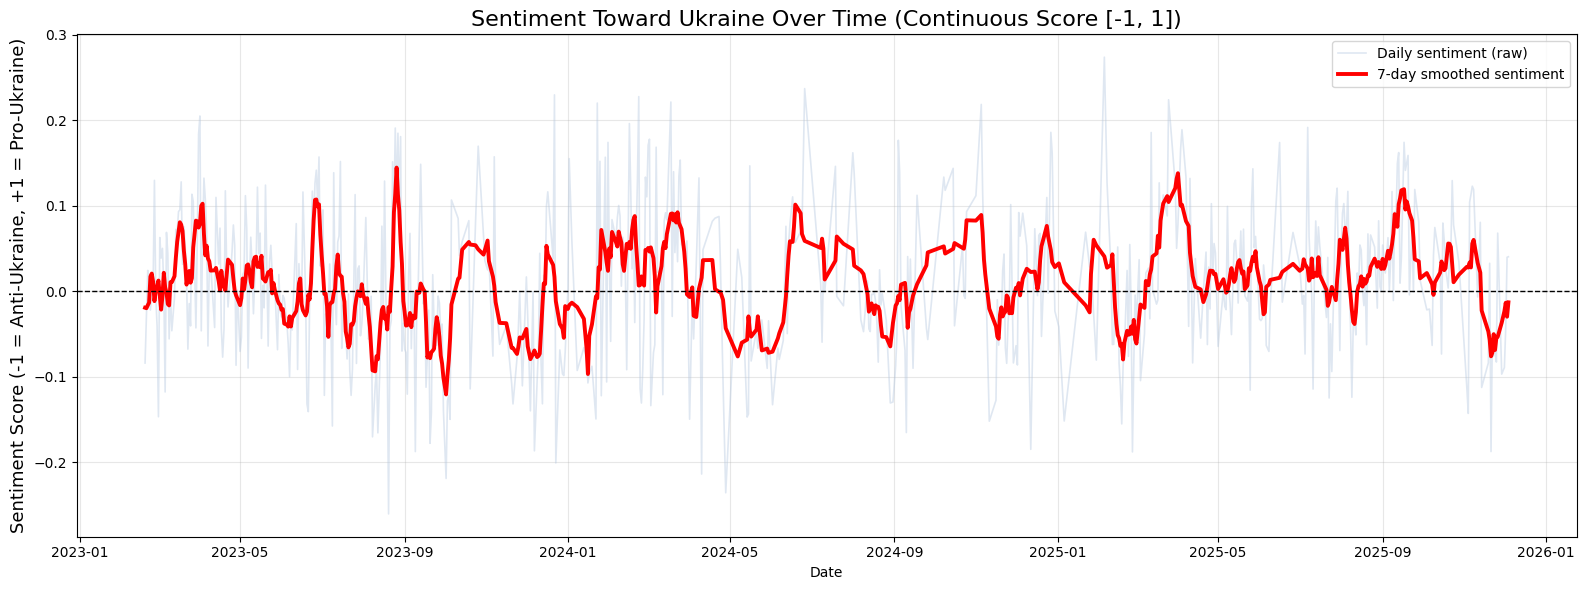

In [22]:
daily = (
    df.groupby("video_published_at")["sentiment_toward_ukraine"]
      .mean()
      .reset_index()
)

daily = daily.rename(columns={"sentiment_toward_ukraine": "daily_sentiment"})

daily["smooth_sentiment"] = (
    daily["daily_sentiment"]
    .rolling(window=7, center=True, min_periods=1)
    .mean()
)

plt.figure(figsize=(16, 6))

plt.plot(
    daily["video_published_at"],
    daily["daily_sentiment"],
    color="lightsteelblue",
    alpha=0.4,
    linewidth=1.2,
    label="Daily sentiment (raw)"
)

plt.plot(
    daily["video_published_at"],
    daily["smooth_sentiment"],
    color="red",
    linewidth=2.8,
    label="7-day smoothed sentiment"
)

plt.axhline(0, linestyle="--", color="black", linewidth=1)

plt.title("Sentiment Toward Ukraine Over Time (Continuous Score [-1, 1])", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sentiment Score (-1 = Anti-Ukraine, +1 = Pro-Ukraine)", fontsize=13)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()

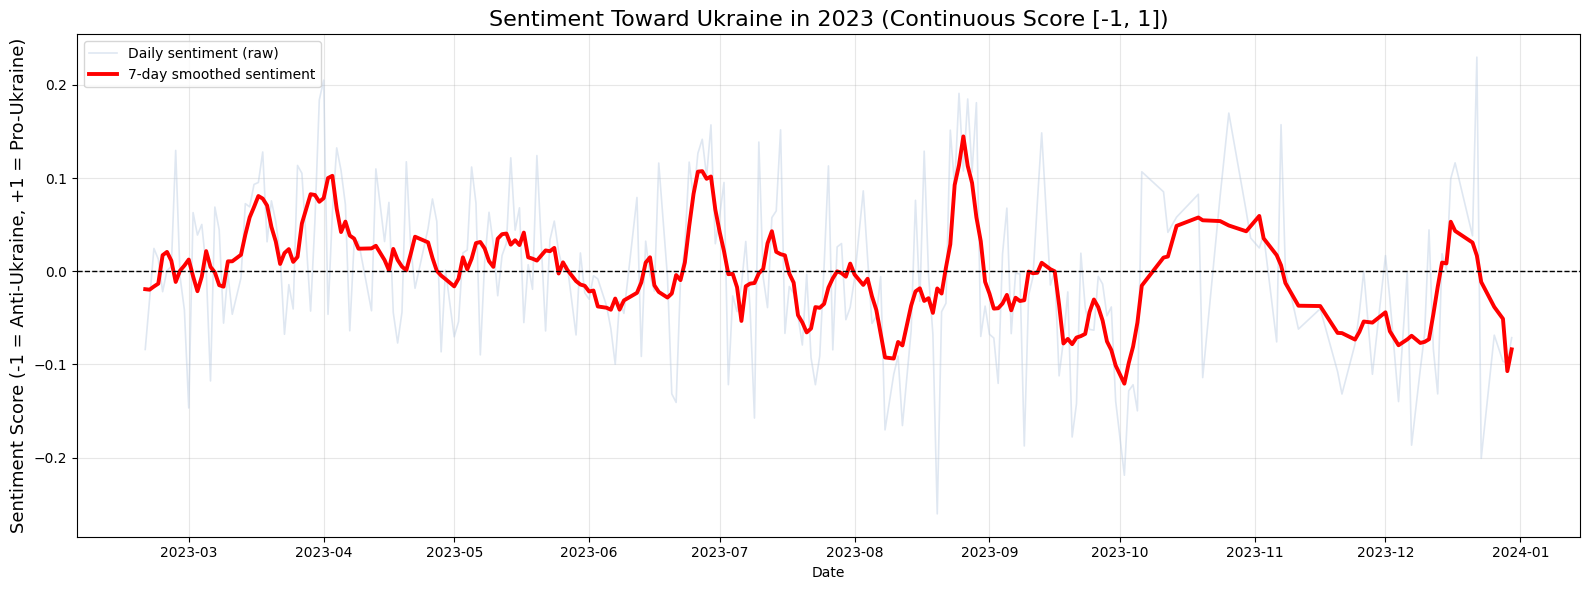

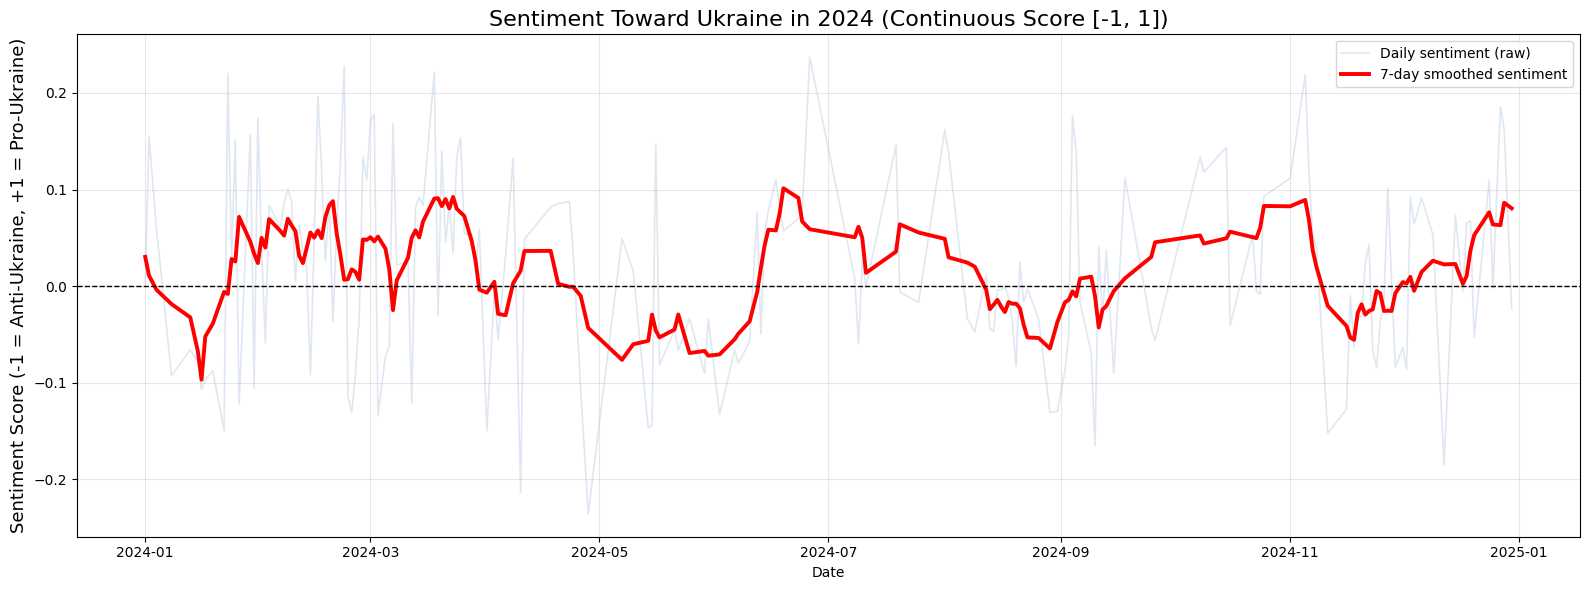

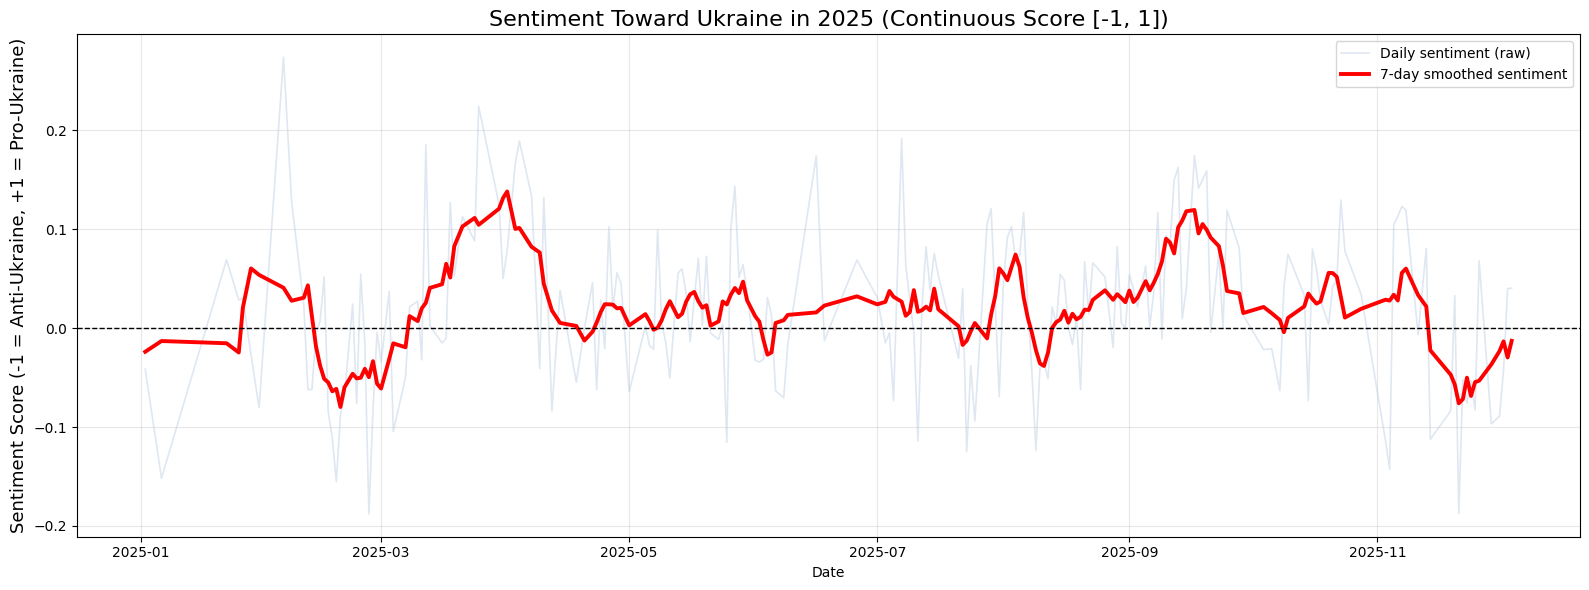

In [23]:
df["year"] = df["video_published_at"].dt.year

unique_years = sorted(df["year"].unique())

for year in unique_years:
    df_year = df[df["year"] == year]

    if len(df_year) < 10:
        print(f"Skipping {year}: not enough data")
        continue

    daily = (
        df_year.groupby("video_published_at")["sentiment_toward_ukraine"]
              .mean()
              .reset_index()
              .rename(columns={"sentiment_toward_ukraine": "daily_sentiment"})
    )

    daily["smooth_sentiment"] = (
        daily["daily_sentiment"]
        .rolling(window=7, center=True, min_periods=1)
        .mean()
    )

    plt.figure(figsize=(16, 6))

    plt.plot(
        daily["video_published_at"],
        daily["daily_sentiment"],
        color="lightsteelblue",
        alpha=0.4,
        linewidth=1.2,
        label="Daily sentiment (raw)"
    )

    plt.plot(
        daily["video_published_at"],
        daily["smooth_sentiment"],
        color="red",
        linewidth=2.8,
        label="7-day smoothed sentiment"
    )

    plt.axhline(0, linestyle="--", color="black", linewidth=1)

    plt.title(f"Sentiment Toward Ukraine in {year} (Continuous Score [-1, 1])", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score (-1 = Anti-Ukraine, +1 = Pro-Ukraine)", fontsize=13)

    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()